# Import

## Library

In [55]:
import pandas as pd
import geopandas as gpd
import missingno as msno
from shapely.geometry import Point
import matplotlib.pyplot as plt
import pandas as pd
import plotly.express as px

2.1. Problemática:
Una consultora de logística naval necesita visualizar los recorridos de distintos buques y analizar su relación con distintas zonas de interés dentro de ArcGIS.

- id_buque: identificador unico de buque.
- type: tipo de embarcacion.
- course: direccion del barco en esa posicion.
- latitude: latitud de la posicion.
- longitude: longitud de la posicion.
- date: fecha de reporte de la posicion.
- Un shp con las zonas de interés (polígonos). Los atributos son los siguientes:
- zone_id
- zone_name
- geometry

2.3. Objetivos:
- Se busca agregar el mayor valor agregado posible con los datos disponibles (por ejemplo, __tiempo de permanencia en las distintas zonas__).
- Para ello se solicita realizar análisis y enriquecimiento de datos utilizando Python (notebook).
- Con la información resultante (csv/shp) publicar las capas en ArcGIS Online.
- Crear un Dashboard dentro del portal que permita analizar los recorridos de los barcos dentro y su relación con las zonas de interés.

## Dataset

### ships.csv

In [56]:
df_ships = pd.read_csv('B:/work/prueba tencica/data/ships.csv',index_col=False)
df_ships.drop(columns=['Unnamed: 0'], inplace=True )
df_ships.head()

id_buque                      type course   latitude  longitude  \
0   8840908  BUQUE TANQUE (PETROLERO)    1.7 -36.087490 -56.198563   
1   8840908  BUQUE TANQUE (PETROLERO)    1.7 -36.087490 -56.198563   
2   8840908  BUQUE TANQUE (PETROLERO)    0.9 -36.139480 -56.196513   
3   8840908  BUQUE TANQUE (PETROLERO)  359.1 -36.302200 -56.191498   
4   8840908  BUQUE TANQUE (PETROLERO)  356.8 -36.316813 -56.190623   

                  date Velocidad         Bandera  
0  2023-03-07 14:47:37      12.7  Islas Marshall  
1  2023-03-07 14:47:37      12.7  Islas Marshall  
2  2023-03-07 14:33:05        13  Islas Marshall  
3  2023-03-07 13:48:08      13.2  Islas Marshall  
4  2023-03-07 13:44:08      13.3  Islas Marshall

In [57]:
df_ships['id_buque'].unique()

array([8840908, 2410206, 2040206,    4415,    7315], dtype=int64)

### zonas.shp

In [58]:
# Leer el archivo SHP
gdf_new = gpd.read_file('B:/work/prueba tencica/data/zonas.shp')
gdf_new.head()

Shape_Leng  Shape_Area zone_id        zone_name  \
0    0.606469    0.002140       2       Rio Parana   
1    9.431244    2.918412       1  Rio de la plata   

                                            geometry  
0  POLYGON ((-58.76149 -34.24093, -58.76007 -34.2...  
1  POLYGON ((-58.51747 -34.44602, -58.45395 -34.3...

In [59]:
gdf_new['zone_name'].unique()

array(['Rio Parana', 'Rio de la plata'], dtype=object)

# MISIGNO ANALISIS


Using the missingno Python library to Identify and Visualise Missing Data 

<AxesSubplot:>

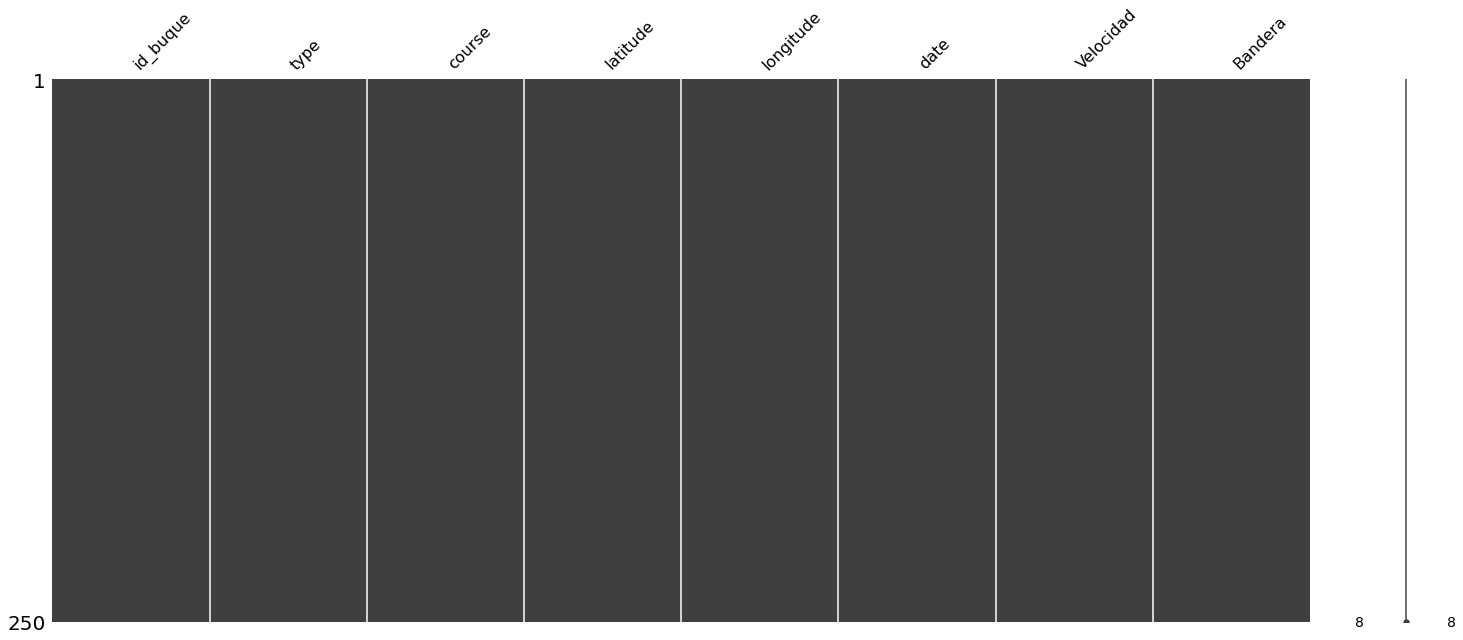

In [60]:
msno.matrix(df_ships.sample(250))

# Plot

## Permanencia

In [61]:
def plot_velocidad(	df_ships_aux , gdf_new_aux ) :

    df_ships = df_ships_aux
    gdf_new = gdf_new_aux

    # Convert the 'date' column to datetime
    df_ships['date'] = pd.to_datetime(df_ships['date'])
    df_ships = df_ships.sort_values(['id_buque', 'date'])

    # Calculate the time difference between each row
    df_ships['time_diff'] = df_ships.groupby('id_buque')['date'].diff()
    df_ships['time_diff'] = df_ships['time_diff'].dt.total_seconds() / 3600
    # Calculate the total time spent by each ship in seconds
    stay_time = df_ships.groupby(['id_buque', 'latitude', 'longitude'])['time_diff'].sum().reset_index()
    # Convert the longitude and latitude to a geometric point
    df_ships['geometry'] = df_ships.apply(lambda row: Point(row.longitude, row.latitude), axis=1)
    # Convert the DataFrame to a GeoDataFrame
    gdf_ships = gpd.GeoDataFrame(df_ships, geometry='geometry')
    # Create a larger figure and axis
    fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    # Plot the zones
    gdf_new.plot(column='zone_name', legend=True, ax=ax)
    # Plot the total time spent by each ship
    gdf_ships.plot(column='time_diff', legend=True, ax=ax, marker='o', markersize=5, cmap='viridis')

    plt.show()

def plot_plotly(data ) :

    # Convert the 'date' column to datetime format
    data['date'] = pd.to_datetime(data['date'])

    # Sort the data by 'id_buque' and 'date'
    data = data.sort_values(['id_buque', 'date'])

    # Calculate the difference in 'date' between each row and the previous row
    data['time_diff'] = data.groupby('id_buque')['date'].diff()

    # Convert the time difference to hours
    data['time_diff'] = data['time_diff'].dt.total_seconds() / 3600

    # Group the data by 'id_buque' and coordinates and calculate the sum of 'time_diff' for each group
    stay_time = data.groupby(['id_buque', 'latitude', 'longitude'])['time_diff'].sum().reset_index()

    # Create a scatter plot on a map, coloring the markers by stay time
    fig = px.scatter_geo(stay_time, lat='latitude', lon='longitude', color='time_diff', hover_name='id_buque', color_continuous_scale=px.colors.sequential.Plasma)

    fig.update_layout(title_text = 'Ship Locations and Stay Time', title_x = 0.5, showlegend = False, geo_scope='world')

    fig.show()

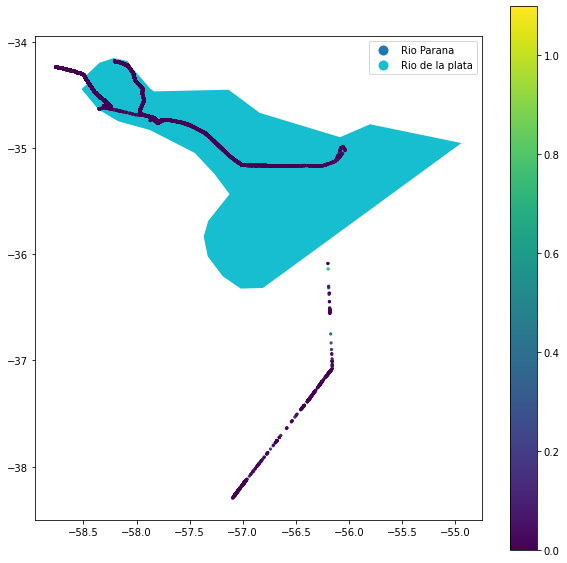

In [62]:
plot_velocidad(df_ships , gdf_new )
plot_plotly(df_ships )

## Gráfico de barras para mostrar la cantidad de barcos por tipo

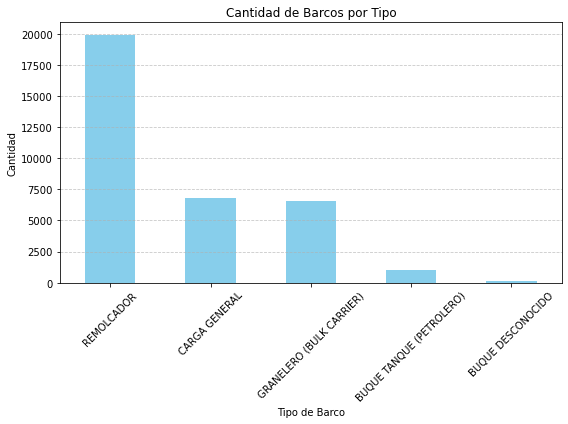

In [63]:
def grafico_barras(data) : 
    plt.figure(figsize=(8, 6))
    data['type'].value_counts().plot(kind='bar', color='skyblue')
    plt.title('Cantidad de Barcos por Tipo')
    plt.xlabel('Tipo de Barco')
    plt.ylabel('Cantidad')
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()

    # Mostrar el gráfico de barras
    plt.show()
    
grafico_barras(df_ships)

## Gráfico de dispersión geográfico para visualizar la ubicación de los barcos en el mapa

In [64]:
def tipo_de_barco(data):
    fig = px.scatter_geo(data, lat='latitude', lon='longitude', color='type', hover_name='id_buque',
                         title='Ubicación de Barcos en el Mapa', color_discrete_sequence=px.colors.qualitative.Pastel)

    fig.update_layout(geo_scope='world')

    # Mostrar el gráfico de dispersión geográfico
    fig.show()

tipo_de_barco(df_ships)